## Imports

In [164]:
#import necessary modules
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import roc_auc_score,confusion_matrix,roc_curve
from sklearn.ensemble import GradientBoostingClassifier,VotingClassifier
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
from sklearn.feature_selection import SelectFromModel
import seaborn as sns
%matplotlib inline

## Read the processed Files and Raw Data

Reading the processed files for Enquiry and Account. The Raw Data files are imported as is. 

In [99]:
#reading the train and test files
raw_train = pd.read_csv(r'/Users/varsha/Downloads/test data/raw_data_70_new.csv',low_memory=False)
raw_test = pd.read_csv(r'/Users/varsha/Downloads/test data/raw_data_30_new.csv',low_memory=False)
#reading the cleaned enquiry file
enq_train = pd.read_csv('/Users/varsha/Downloads/test data/trainEnquiry.csv')
enq_test = pd.read_csv('/Users/varsha/Downloads/test data/testEnquiry.csv')
#reading the cleaned enquiry file
acc_train = pd.read_csv('/Users/varsha/Downloads/test data/trainAccount.csv')
acc_test = pd.read_csv('/Users/varsha/Downloads/test data/testAccount.csv')



In [100]:
#list of columns selected
col_list = ['customer_no', 'feature_20', 'feature_11', 'Bad_label']
raw_train = raw_train[col_list]
raw_test = raw_test[col_list]

In [101]:
#Rename the columns 
raw_train.rename(columns={'feature_20': 'cibil_score', 'feature_11': 'marital_status'}, inplace=True)
raw_test.rename(columns={'feature_20': 'cibil_score', 'feature_11': 'marital_status'}, inplace=True)
col_list = ['customer_no', 'cibil_score', 'marital_status', 'Bad_label']

In [102]:
#merge all the data sets to create the train and test sets
train = pd.merge(raw_train,enq_train,on='customer_no', how='inner')
test  = pd.merge(raw_test,enq_test,on='customer_no', how='inner')
train = pd.merge(train,acc_train,on='customer_no',how='inner')
test = pd.merge(test,acc_test,on='customer_no',how='inner')


In [103]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23896 entries, 0 to 23895
Data columns (total 19 columns):
customer_no           23896 non-null int64
cibil_score           23896 non-null object
marital_status        23881 non-null object
Bad_label             23896 non-null int64
365_days              23896 non-null float64
90_days               23896 non-null float64
openDays              23896 non-null float64
enq_amt               23787 non-null float64
cashlimit             23896 non-null float64
total_creditlimit     23896 non-null float64
total_currentlimit    23896 non-null int64
mean_creditlimit      23896 non-null float64
mean_currentlimit     23896 non-null float64
mean_Days             23896 non-null float64
total_Days            23896 non-null float64
monthlength           23896 non-null float64
paymentBoolean        23896 non-null float64
least_30dpd           23896 non-null float64
max_30dpd             23896 non-null float64
dtypes: float64(14), int64(3), object(2)
mem

In [106]:
#get the dummies for train and test data
train['cibil_score']=pd.get_dummies(train['cibil_score'],drop_first=True)
train['marital_status']=pd.get_dummies(train['marital_status'],drop_first=True)
test['cibil_score']=pd.get_dummies(test['cibil_score'],drop_first=True)
test['marital_status']=pd.get_dummies(test['marital_status'],drop_first=True)

In [108]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23896 entries, 0 to 23895
Data columns (total 19 columns):
customer_no           23896 non-null int64
cibil_score           23896 non-null uint8
marital_status        23896 non-null uint8
Bad_label             23896 non-null int64
365_days              23896 non-null float64
90_days               23896 non-null float64
openDays              23896 non-null float64
enq_amt               23787 non-null float64
cashlimit             23896 non-null float64
total_creditlimit     23896 non-null float64
total_currentlimit    23896 non-null int64
mean_creditlimit      23896 non-null float64
mean_currentlimit     23896 non-null float64
mean_Days             23896 non-null float64
total_Days            23896 non-null float64
monthlength           23896 non-null float64
paymentBoolean        23896 non-null float64
least_30dpd           23896 non-null float64
max_30dpd             23896 non-null float64
dtypes: float64(14), int64(3), uint8(2)
memory

Merging the Train and Test Files

In [109]:
#concat train and test
df = pd.concat([train,test]).reset_index(drop=True)

In [61]:
#fill the missing columns
df['cibil_score'] = df['cibil_score'].fillna(0)
df['marital_status'] = df['marital_status'].fillna(2)

In [111]:
# features for training
df_col = ['365_days','90_days','openDays','mean_Days','total_Days','monthlength','paymentBoolean','least_30dpd','max_30dpd'] + Col_list
df = df[df_col]

In [113]:
# split the train and test
df_train = df[0:len(train)]
df_test = df[len(train):len(df)]

In [114]:
#predict column for training and testing data
trainPredicted = df_train['Bad_label']
testPredicted =df_test['Bad_label']


In [116]:
trainPredicted.head(10)

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    1
9    0
Name: Bad_label, dtype: int64

In [117]:
# removing column for creation of features for training  and testing
df_train = df_train[df_train.columns.difference(['customer_no', 'Bad_label'])]
df_test = df_test[df_test.columns.difference(['customer_no', 'Bad_label'])]

In [118]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23896 entries, 0 to 23895
Data columns (total 11 columns):
365_days          23896 non-null float64
90_days           23896 non-null float64
cibil_score       23896 non-null uint8
least_30dpd       23896 non-null float64
marital_status    23896 non-null uint8
max_30dpd         23896 non-null float64
mean_Days         23896 non-null float64
monthlength       23896 non-null float64
openDays          23896 non-null float64
paymentBoolean    23896 non-null float64
total_Days        23896 non-null float64
dtypes: float64(9), uint8(2)
memory usage: 1.7 MB


In [119]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10240 entries, 23896 to 34135
Data columns (total 11 columns):
365_days          10240 non-null float64
90_days           10240 non-null float64
cibil_score       10240 non-null uint8
least_30dpd       10240 non-null float64
marital_status    10240 non-null uint8
max_30dpd         10240 non-null float64
mean_Days         10240 non-null float64
monthlength       10240 non-null float64
openDays          10240 non-null float64
paymentBoolean    10240 non-null float64
total_Days        10240 non-null float64
dtypes: float64(9), uint8(2)
memory usage: 740.1 KB


In [126]:
# initialize the models for Gradient Boosting Classifier
model = GradientBoostingClassifier(learning_rate=0.01)
model.fit(df_train,trainPredicted)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [127]:
# predicting of model
predicted = model.predict(df_test)
# proba of model
proba = model.predict_proba(df_test)

[ 0.12598499  0.18333843  0.          0.05486827  0.          0.08278029
  0.06325037  0.0402183   0.16069238  0.04343431  0.24543264]


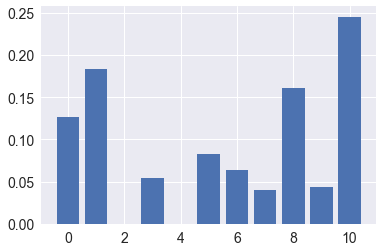

In [167]:
print(model.feature_importances_)
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()

In [129]:
#accuracy of the model
predictions = [round(value) for value in predicted]
accuracy = accuracy_score(testPredicted, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 95.49%


In [160]:
# calculate the confusion matrix
confusion_matrix(testPredicted,predicted)


array([[9778,    0],
       [ 462,    0]])

In [131]:
 # rocscore calculation
2*(roc_auc_score(testPredicted, proba[:, 1])) -1

0.24641965043887737

In [132]:
#rank ordering 
proba0 = proba[:, 0]
proba1 = proba[:, 1]
proba0 = sorted(proba0, reverse=True)
proba1 = sorted(proba1, reverse=True)
final0 = np.percentile(proba0, np.arange(0, 100, 10))
final1 = np.percentile(proba1, np.arange(0, 100, 10))

In [133]:
total = final1 + final0
print (total)


[ 0.818684    0.97514274  0.98381525  0.99251904  0.99537651  1.
  1.00462349  1.00748096  1.01618475  1.02485726]


In [ ]:
#TODO Plot RANK Ordering

In [135]:
model2 = XGBClassifier(learning_rate=0.01)
model2.fit(df_train, trainPredicted)
print(model2)
predicted_2 = model2.predict(df_test)
predictions_2 = [round(value) for value in predicted_2]
accuracy = accuracy_score(testPredicted, predictions_2)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
Accuracy: 95.49%


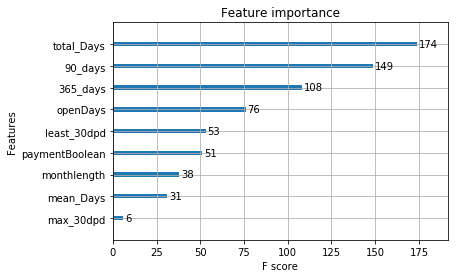

In [144]:
#Feature Importance Plot
plot_importance(model2)
pyplot.show()